# GARCH Simulation Example

This notebook demonstrates the GARCH simulation capabilities by generating 5 scenarios over 200 timesteps.

## Setup

We'll use the GJR-GARCH model with Hansen's skewed t-distribution for the innovations.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from density_engine.garch import GJRGARCH_torch
from density_engine.skew_student_t import HansenSkewedT_torch

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# GARCH parameters
mu = 0.0005      # Mean return
omega = 0.0001   # Base variance
alpha = 0.05     # ARCH coefficient
gamma = 0.03     # GJR asymmetry coefficient
beta = 0.90      # GARCH coefficient
sigma0_sq = 0.0004  # Initial variance

# Hansen's skewed t-distribution parameters
eta = 5.0        # Degrees of freedom
lam = -0.1       # Skewness parameter

# Create the distribution
dist = HansenSkewedT_torch(eta=eta, lam=lam)

# Create GARCH model
garch = GJRGARCH_torch(
    mu=mu,
    omega=omega,
    alpha=alpha,
    gamma=gamma,
    beta=beta,
    sigma0_sq=sigma0_sq,
    dist=dist
)

print("GARCH Model Parameters:")
print(f"  Mean return (μ): {mu}")
print(f"  Base variance (ω): {omega}")
print(f"  ARCH coefficient (α): {alpha}")
print(f"  GJR coefficient (γ): {gamma}")
print(f"  GARCH coefficient (β): {beta}")
print(f"  Initial variance (σ₀²): {sigma0_sq}")
print(f"  Skewed t parameters: η={eta}, λ={lam}")
print(f"  Stationarity check: κ = α + β + γ·P₀ = {garch.kappa:.4f} < 1.0")


GARCH Model Parameters:
  Mean return (μ): 0.0005
  Base variance (ω): 0.0001
  ARCH coefficient (α): 0.05
  GJR coefficient (γ): 0.03
  GARCH coefficient (β): 0.9
  Initial variance (σ₀²): 0.0004
  Skewed t parameters: η=5.0, λ=-0.1
  Stationarity check: κ = α + β + γ·P₀ = 0.9662 < 1.0


In [2]:
# Simulation parameters
num_scenarios = 5
num_timesteps = 200

# Initialize the GARCH model
garch.reset(num_scenarios)

# Store results
returns = np.zeros((num_timesteps, num_scenarios))
volatilities = np.zeros((num_timesteps, num_scenarios))
cumulative_returns = np.zeros((num_timesteps, num_scenarios))

# Run simulation
for t in range(num_timesteps):
    cum_ret, current_t = garch.step()
    
    # Store cumulative returns
    cumulative_returns[t] = cum_ret.detach().cpu().numpy()
    
    # Store volatilities (standard deviation)
    volatilities[t] = torch.sqrt(garch.var).detach().cpu().numpy()
    
    # Calculate period returns (difference from previous cumulative return)
    if t == 0:
        returns[t] = cum_ret.detach().cpu().numpy()
    else:
        returns[t] = cum_ret.detach().cpu().numpy() - cumulative_returns[t-1]

print(f"Simulation completed: {num_scenarios} scenarios over {num_timesteps} timesteps")
print(f"Final cumulative returns: {cumulative_returns[-1]}")
print(f"Average final volatility: {np.mean(volatilities[-1]):.4f}")


Simulation completed: 5 scenarios over 200 timesteps
Final cumulative returns: [ 0.4681012   0.12578101 -0.61098206 -0.33176395  0.93684697]
Average final volatility: 0.0469


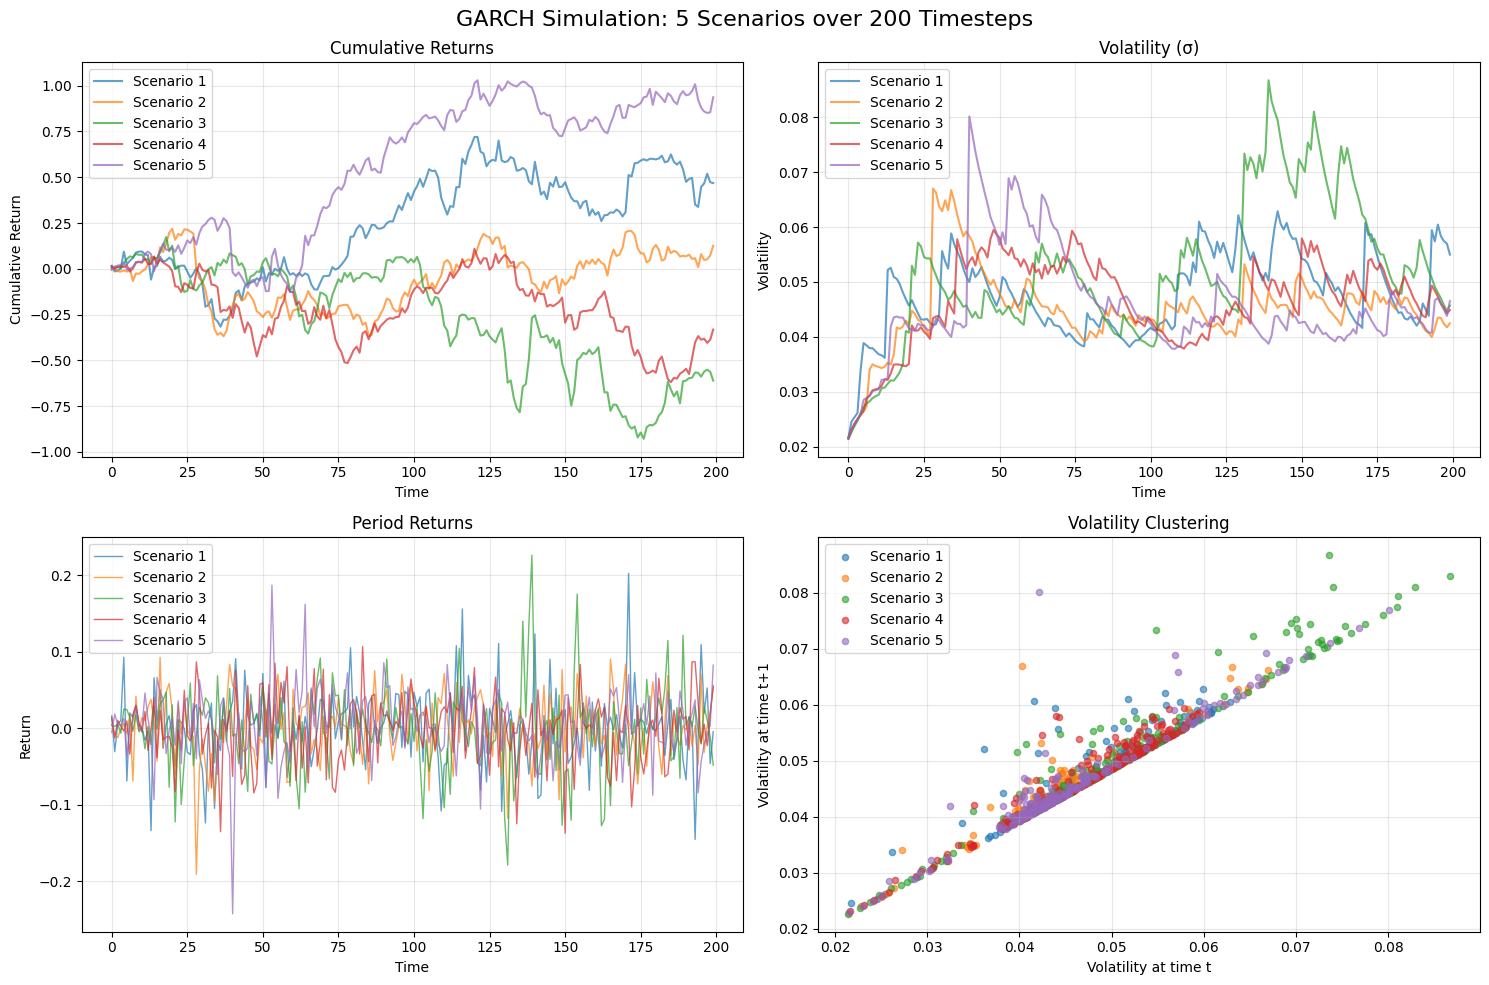

In [3]:
# Create comprehensive plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('GARCH Simulation: 5 Scenarios over 200 Timesteps', fontsize=16)

# Plot 1: Cumulative Returns
ax1 = axes[0, 0]
for i in range(num_scenarios):
    ax1.plot(cumulative_returns[:, i], alpha=0.7, linewidth=1.5, label=f'Scenario {i+1}')
ax1.set_title('Cumulative Returns')
ax1.set_xlabel('Time')
ax1.set_ylabel('Cumulative Return')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Volatility (Standard Deviation)
ax2 = axes[0, 1]
for i in range(num_scenarios):
    ax2.plot(volatilities[:, i], alpha=0.7, linewidth=1.5, label=f'Scenario {i+1}')
ax2.set_title('Volatility (σ)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Volatility')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Period Returns
ax3 = axes[1, 0]
for i in range(num_scenarios):
    ax3.plot(returns[:, i], alpha=0.7, linewidth=1.0, label=f'Scenario {i+1}')
ax3.set_title('Period Returns')
ax3.set_xlabel('Time')
ax3.set_ylabel('Return')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot 4: Volatility Clustering (Volatility vs Lagged Volatility)
ax4 = axes[1, 1]
for i in range(num_scenarios):
    ax4.scatter(volatilities[:-1, i], volatilities[1:, i], alpha=0.6, s=20, label=f'Scenario {i+1}')
ax4.set_title('Volatility Clustering')
ax4.set_xlabel('Volatility at time t')
ax4.set_ylabel('Volatility at time t+1')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()


\nDemonstrating the path() method:
Time points: [50, 100, 150, 200]
Path results shape: torch.Size([4, 5])
Cumulative returns at each time point:
  Time  50: [-0.21735099  0.07797133  0.00705538  0.07593257  0.25793496]
  Time 100: [-0.1752112  -0.02551274  0.32254842 -0.47114033  0.02063624]
  Time 150: [-0.30503017 -0.11993571 -0.17596115 -0.2897542   1.0334433 ]
  Time 200: [-0.30310985  0.18927404 -0.40359578 -0.19769347  0.5815947 ]


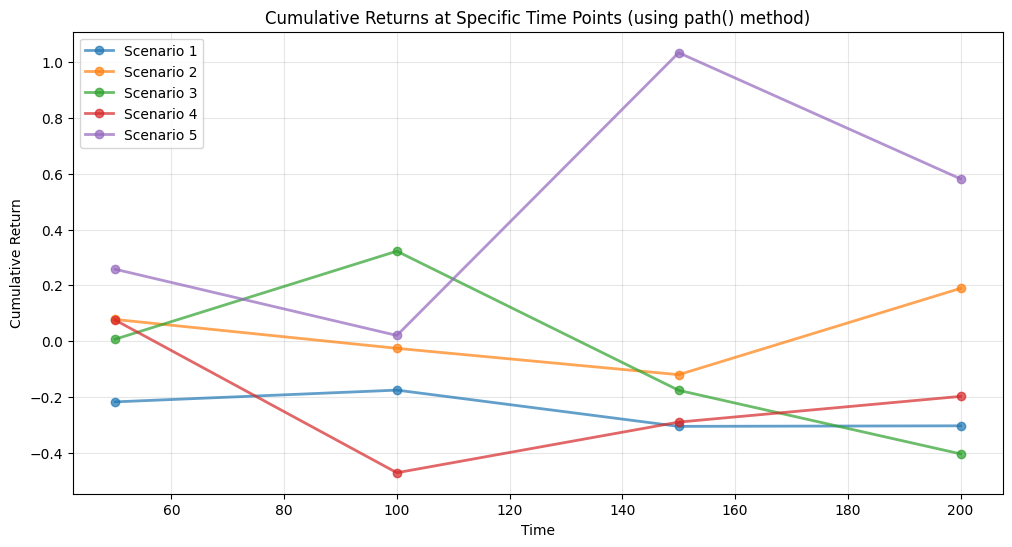

In [4]:
# Demonstrate the path() method
print("\\nDemonstrating the path() method:")
print("=" * 50)

# Reset for path demonstration
garch.reset(num_scenarios)

# Use path() method to get cumulative returns at specific time points
time_points = [50, 100, 150, 200]
path_results = garch.path(time_points)

print(f"Time points: {time_points}")
print(f"Path results shape: {path_results.shape}")
print("Cumulative returns at each time point:")
for i, t in enumerate(time_points):
    print(f"  Time {t:3d}: {path_results[i].detach().cpu().numpy()}")

# Plot the path results
plt.figure(figsize=(12, 6))
for i in range(num_scenarios):
    plt.plot(time_points, path_results[:, i].detach().cpu().numpy(), 
             'o-', alpha=0.7, linewidth=2, markersize=6, label=f'Scenario {i+1}')

plt.title('Cumulative Returns at Specific Time Points (using path() method)')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [5]:
# Summary statistics
print("\\nSummary Statistics:")
print("=" * 50)

# Calculate summary statistics across all scenarios
final_returns = cumulative_returns[-1]
avg_volatility = np.mean(volatilities, axis=0)
max_drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns, axis=0), axis=0)

print(f"Final cumulative returns:")
for i, ret in enumerate(final_returns):
    print(f"  Scenario {i+1}: {ret:.4f}")

print(f"\\nAverage volatility per scenario:")
for i, vol in enumerate(avg_volatility):
    print(f"  Scenario {i+1}: {vol:.4f}")

print(f"\\nMaximum drawdown per scenario:")
for i, dd in enumerate(max_drawdown):
    print(f"  Scenario {i+1}: {dd:.4f}")

print(f"\\nOverall statistics:")
print(f"  Mean final return: {np.mean(final_returns):.4f}")
print(f"  Std final return: {np.std(final_returns):.4f}")
print(f"  Mean volatility: {np.mean(avg_volatility):.4f}")
print(f"  Mean max drawdown: {np.mean(max_drawdown):.4f}")


\nSummary Statistics:
Final cumulative returns:
  Scenario 1: 0.4681
  Scenario 2: 0.1258
  Scenario 3: -0.6110
  Scenario 4: -0.3318
  Scenario 5: 0.9368
\nAverage volatility per scenario:
  Scenario 1: 0.0477
  Scenario 2: 0.0451
  Scenario 3: 0.0516
  Scenario 4: 0.0466
  Scenario 5: 0.0456
\nMaximum drawdown per scenario:
  Scenario 1: -0.4598
  Scenario 2: -0.5873
  Scenario 3: -1.1017
  Scenario 4: -0.7281
  Scenario 5: -0.4063
\nOverall statistics:
  Mean final return: 0.1176
  Std final return: 0.5526
  Mean volatility: 0.0473
  Mean max drawdown: -0.6566


In [6]:
# Surface Plot of Quantiles Over Time
print("Generating quantile surface plots for both GARCH processes...")
print("=" * 60)

# Import additional libraries for 3D plotting
from mpl_toolkits.mplot3d import Axes3D
from density_engine.garch import GJRGARCHReduced_torch

# Set up parameters for quantile computation
time_points = list(range(1, 201))  # Time 1 to 200
num_paths = 10000  # Large number of paths for accurate quantiles
quantile_size = 100  # Number of quantiles to compute

# Create both GARCH models
print("Creating GARCH models...")

# Standard GARCH (raw model)
garch_standard = GJRGARCH_torch(
    mu=mu,
    omega=omega,
    alpha=alpha,
    gamma=gamma,
    beta=beta,
    sigma0_sq=sigma0_sq,
    dist=dist
)

# Reduced GARCH (normalized model)
garch_reduced = GJRGARCHReduced_torch(
    alpha=alpha,
    gamma=gamma,
    beta=beta,
    sigma0_sq=sigma0_sq / garch_standard.v,  # Normalize initial variance
    dist=dist
)

print(f"Standard GARCH kappa: {garch_standard.kappa:.4f}")
print(f"Reduced GARCH kappa: {garch_reduced.kappa:.4f}")
print(f"Long-run variance (v): {garch_standard.v:.6f}")
print(f"Number of paths: {num_paths}")
print(f"Time points: {len(time_points)} (1 to 200)")
print(f"Quantile size: {quantile_size}")


Generating quantile surface plots for both GARCH processes...
Creating GARCH models...
Standard GARCH kappa: 0.9662
Reduced GARCH kappa: 0.9662
Long-run variance (v): 0.002963
Number of paths: 10000
Time points: 200 (1 to 200)
Quantile size: 100


In [7]:
# Compute quantiles for both models
print("Computing quantiles for standard GARCH model...")
garch_standard.reset(num_paths)
quantiles_standard = garch_standard.path_quantiles(time_points, size=quantile_size)

print("Computing quantiles for reduced GARCH model...")
garch_reduced.reset(num_paths)
quantiles_reduced = garch_reduced.path_quantiles(time_points, size=quantile_size)

# Convert to numpy for plotting
quantiles_standard_np = quantiles_standard.detach().cpu().numpy()
quantiles_reduced_np = quantiles_reduced.detach().cpu().numpy()

print(f"Standard GARCH quantiles shape: {quantiles_standard_np.shape}")
print(f"Reduced GARCH quantiles shape: {quantiles_reduced_np.shape}")

# Create meshgrids for surface plotting
T, Q = np.meshgrid(time_points, np.linspace(0.001, 0.999, quantile_size))

print("Quantile computation completed!")


Computing quantiles for standard GARCH model...
Computing quantiles for reduced GARCH model...
Standard GARCH quantiles shape: (200, 100)
Reduced GARCH quantiles shape: (200, 100)
Quantile computation completed!


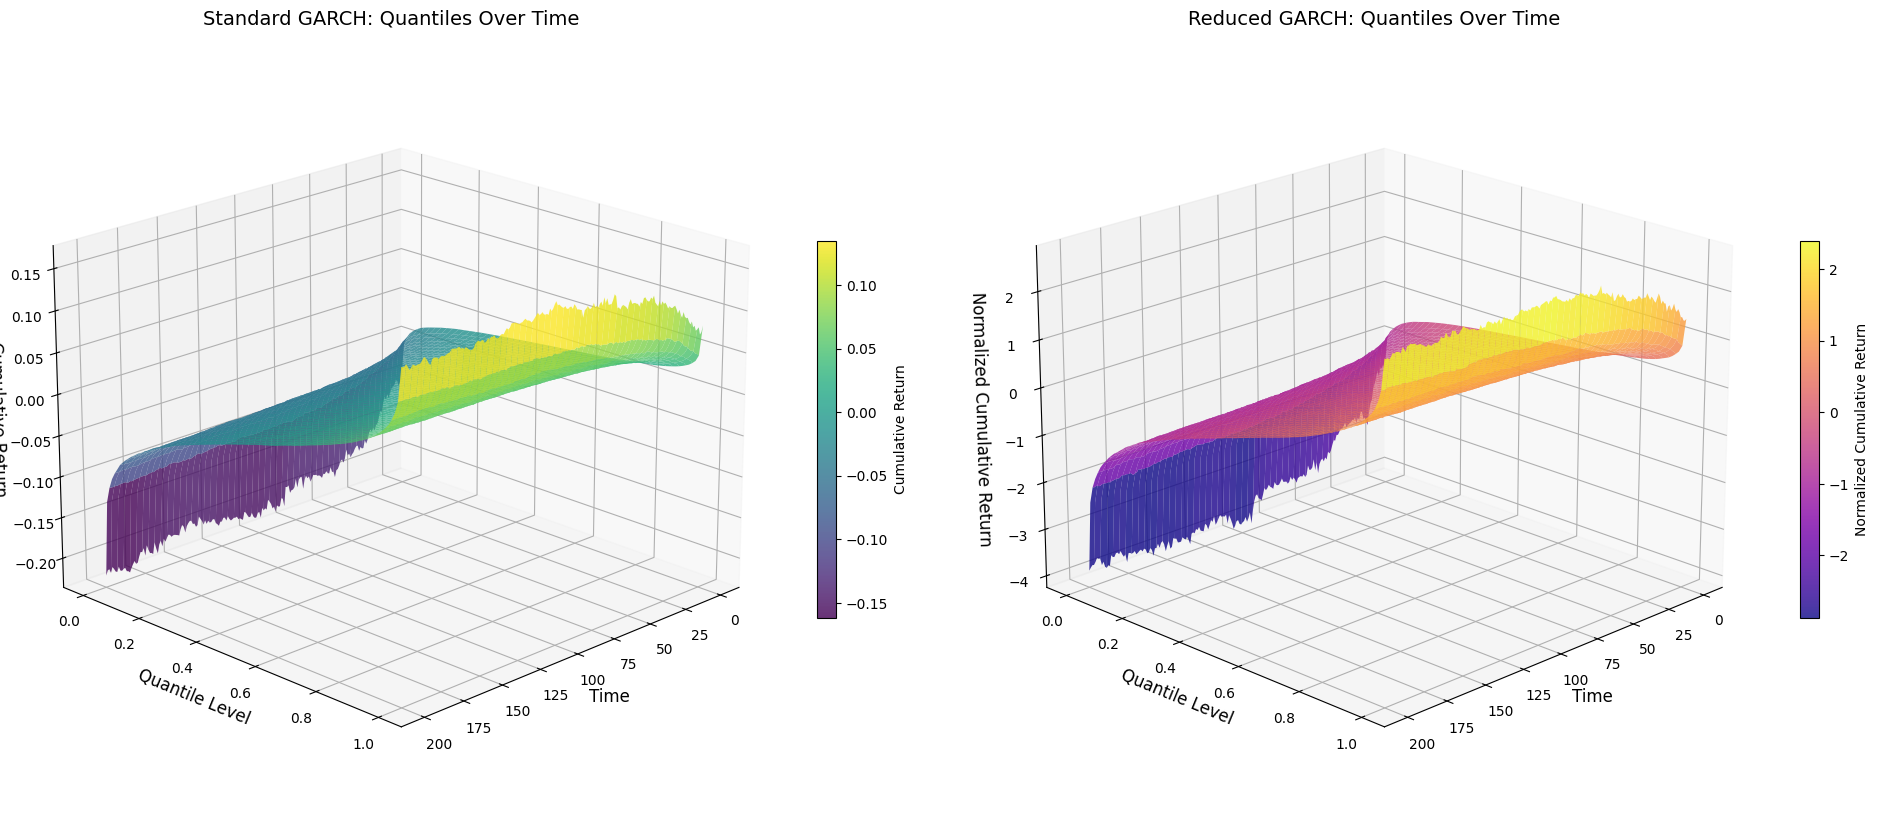


Surface Plot Statistics:
Standard GARCH quantile range: [-0.2280, 0.1688]
Reduced GARCH quantile range: [-4.1082, 2.8002]
Standard GARCH mean at t=200: -0.0004
Reduced GARCH mean at t=200: -0.0066


In [8]:
# Create surface plots
fig = plt.figure(figsize=(20, 8))

# Standard GARCH Surface Plot
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(T, Q, quantiles_standard_np.T, cmap='viridis', alpha=0.8)
ax1.set_title('Standard GARCH: Quantiles Over Time', fontsize=14, pad=20)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Quantile Level', fontsize=12)
ax1.set_zlabel('Cumulative Return', fontsize=12)
ax1.view_init(elev=20, azim=45)

# Add colorbar
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=20)
cbar1.set_label('Cumulative Return', fontsize=10)

# Reduced GARCH Surface Plot
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(T, Q, quantiles_reduced_np.T, cmap='plasma', alpha=0.8)
ax2.set_title('Reduced GARCH: Quantiles Over Time', fontsize=14, pad=20)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Quantile Level', fontsize=12)
ax2.set_zlabel('Normalized Cumulative Return', fontsize=12)
ax2.view_init(elev=20, azim=45)

# Add colorbar
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=20)
cbar2.set_label('Normalized Cumulative Return', fontsize=10)

plt.tight_layout()
plt.show()

# Print some statistics
print("\nSurface Plot Statistics:")
print("=" * 40)
print(f"Standard GARCH quantile range: [{quantiles_standard_np.min():.4f}, {quantiles_standard_np.max():.4f}]")
print(f"Reduced GARCH quantile range: [{quantiles_reduced_np.min():.4f}, {quantiles_reduced_np.max():.4f}]")
print(f"Standard GARCH mean at t=200: {quantiles_standard_np[-1].mean():.4f}")
print(f"Reduced GARCH mean at t=200: {quantiles_reduced_np[-1].mean():.4f}")


In [9]:
# Compare Return Paths for Both Models
print("Comparing return paths for both GARCH models...")
print("=" * 50)

# Set up parameters for path comparison
num_paths_comparison = 1000  # Fewer paths for clearer visualization
time_points_comparison = list(range(1, 201))  # Time 1 to 200

# Generate paths for both models
print("Generating paths for standard GARCH...")
garch_standard.reset(num_paths_comparison)
paths_standard = garch_standard.path(time_points_comparison)

print("Generating paths for reduced GARCH...")
garch_reduced.reset(num_paths_comparison)
paths_reduced = garch_reduced.path(time_points_comparison)

# Convert to numpy
paths_standard_np = paths_standard.detach().cpu().numpy()
paths_reduced_np = paths_reduced.detach().cpu().numpy()

print(f"Standard GARCH paths shape: {paths_standard_np.shape}")
print(f"Reduced GARCH paths shape: {paths_reduced_np.shape}")
print(f"Standard GARCH range: [{paths_standard_np.min():.4f}, {paths_standard_np.max():.4f}]")
print(f"Reduced GARCH range: [{paths_reduced_np.min():.4f}, {paths_reduced_np.max():.4f}]")


Comparing return paths for both GARCH models...
Generating paths for standard GARCH...
Generating paths for reduced GARCH...
Standard GARCH paths shape: (200, 1000)
Reduced GARCH paths shape: (200, 1000)
Standard GARCH range: [-6.1461, 2.9087]
Reduced GARCH range: [-67.7391, 56.3192]


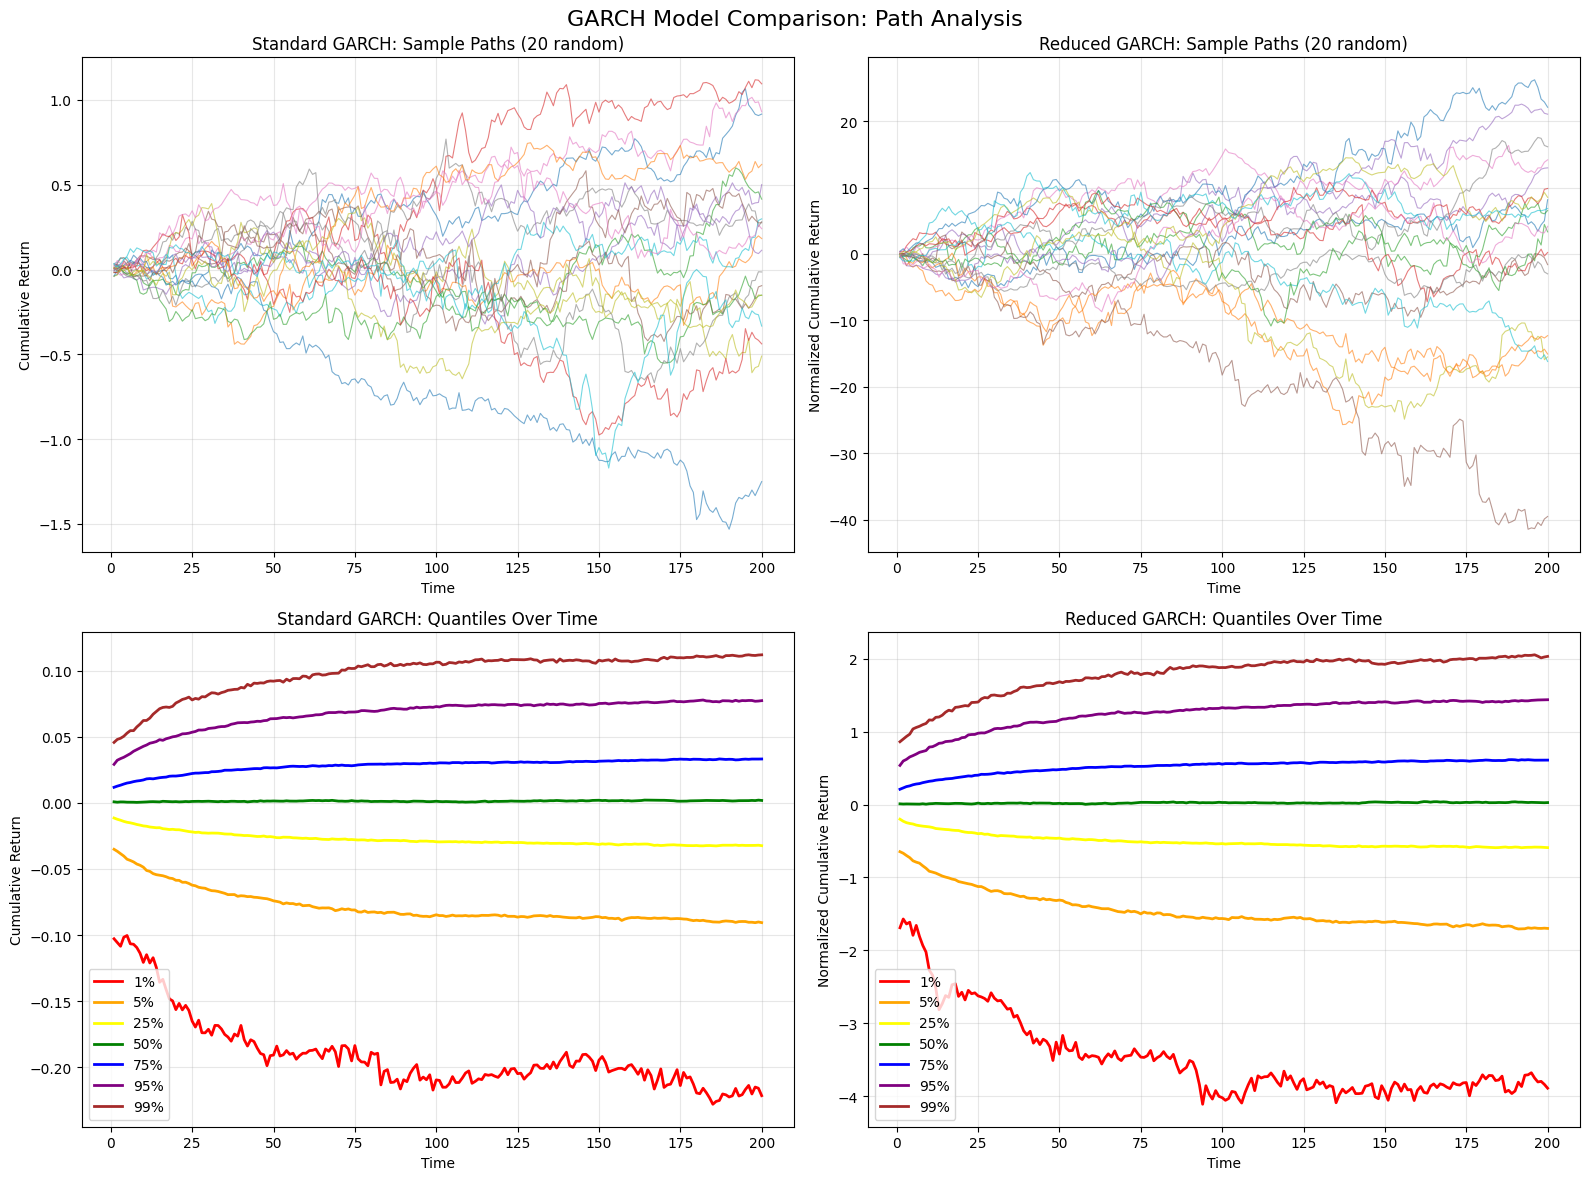


Detailed Statistics:
Standard GARCH:
  Mean at t=200: 0.1334
  Std at t=200: 0.7143
  Range at t=200: [-2.5153, 2.8510]

Reduced GARCH:
  Mean at t=200: -0.3286
  Std at t=200: 13.8123
  Range at t=200: [-60.2784, 55.1026]

Theoretical Analysis:
  Long-run variance (v): 0.002963
  sqrt(v): 0.054430
  Expected scaling factor: 0.054430
  Reduced GARCH should be scaled by sqrt(v) to match standard GARCH


In [10]:
# Create path comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('GARCH Model Comparison: Path Analysis', fontsize=16)

# Plot 1: Standard GARCH - Sample paths
ax1 = axes[0, 0]
sample_indices = np.random.choice(num_paths_comparison, 20, replace=False)  # Show 20 random paths
for idx in sample_indices:
    ax1.plot(time_points_comparison, paths_standard_np[:, idx], alpha=0.6, linewidth=0.8)
ax1.set_title('Standard GARCH: Sample Paths (20 random)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Cumulative Return')
ax1.grid(True, alpha=0.3)

# Plot 2: Reduced GARCH - Sample paths
ax2 = axes[0, 1]
for idx in sample_indices:
    ax2.plot(time_points_comparison, paths_reduced_np[:, idx], alpha=0.6, linewidth=0.8)
ax2.set_title('Reduced GARCH: Sample Paths (20 random)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Normalized Cumulative Return')
ax2.grid(True, alpha=0.3)

# Plot 3: Standard GARCH - Quantiles over time
ax3 = axes[1, 0]
quantiles_to_plot = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown']
for i, q in enumerate(quantiles_to_plot):
    q_idx = int(q * (quantile_size - 1))  # Convert quantile to index
    ax3.plot(time_points_comparison, quantiles_standard_np[:, q_idx], 
             color=colors[i], linewidth=2, label=f'{q:.0%}')
ax3.set_title('Standard GARCH: Quantiles Over Time')
ax3.set_xlabel('Time')
ax3.set_ylabel('Cumulative Return')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Reduced GARCH - Quantiles over time
ax4 = axes[1, 1]
for i, q in enumerate(quantiles_to_plot):
    q_idx = int(q * (quantile_size - 1))  # Convert quantile to index
    ax4.plot(time_points_comparison, quantiles_reduced_np[:, q_idx], 
             color=colors[i], linewidth=2, label=f'{q:.0%}')
ax4.set_title('Reduced GARCH: Quantiles Over Time')
ax4.set_xlabel('Time')
ax4.set_ylabel('Normalized Cumulative Return')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Statistics:")
print("=" * 50)
print("Standard GARCH:")
print(f"  Mean at t=200: {paths_standard_np[-1].mean():.4f}")
print(f"  Std at t=200: {paths_standard_np[-1].std():.4f}")
print(f"  Range at t=200: [{paths_standard_np[-1].min():.4f}, {paths_standard_np[-1].max():.4f}]")

print("\nReduced GARCH:")
print(f"  Mean at t=200: {paths_reduced_np[-1].mean():.4f}")
print(f"  Std at t=200: {paths_reduced_np[-1].std():.4f}")
print(f"  Range at t=200: [{paths_reduced_np[-1].min():.4f}, {paths_reduced_np[-1].max():.4f}]")

# Check the theoretical relationship
print(f"\nTheoretical Analysis:")
print(f"  Long-run variance (v): {garch_standard.v:.6f}")
print(f"  sqrt(v): {garch_standard.sqrt_v:.6f}")
print(f"  Expected scaling factor: {garch_standard.sqrt_v:.6f}")
print(f"  Reduced GARCH should be scaled by sqrt(v) to match standard GARCH")


Verifying the relationship between Standard and Reduced GARCH...
At t=200:
  μ * t = 0.000500 * 200 = 0.1000
  √v = 0.054430

Comparison at t=200:
  Standard GARCH mean: 0.1334
  Reduced GARCH scaled mean: 0.0821
  Difference: 0.051241

  Standard GARCH std: 0.7143
  Reduced GARCH scaled std: 0.7518
  Difference: 0.037511


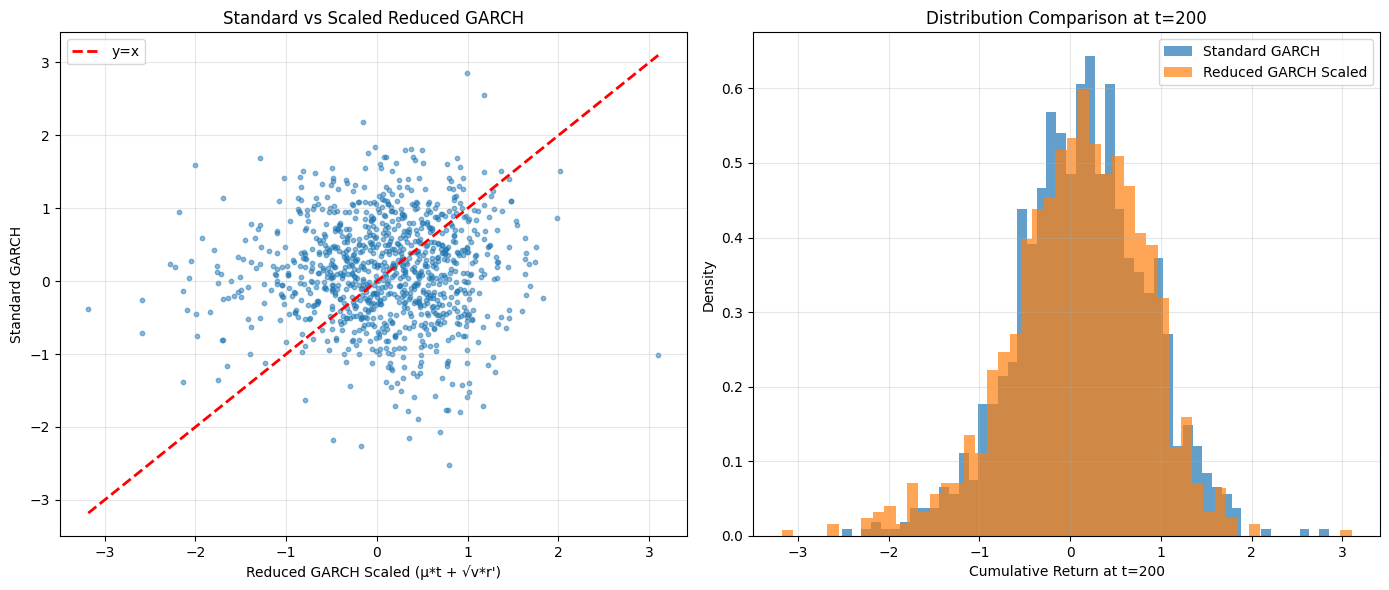


The relationship r_t = μ*t + √v*r'_t appears to be ✗ INCORRECT


In [11]:
# Verify the relationship between Standard and Reduced GARCH
print("Verifying the relationship between Standard and Reduced GARCH...")
print("=" * 60)

# The relationship should be: r_t = μ*t + √v * r'_t
# where r_t is standard GARCH and r'_t is reduced GARCH

# Calculate the theoretical scaling
mu_t = mu * 200  # μ * t for t=200
sqrt_v_scaling = garch_standard.sqrt_v

print(f"At t=200:")
print(f"  μ * t = {mu:.6f} * 200 = {mu_t:.4f}")
print(f"  √v = {sqrt_v_scaling:.6f}")

# Check if reduced GARCH scaled matches standard GARCH
reduced_scaled = mu_t + sqrt_v_scaling * paths_reduced_np[-1]  # Scale reduced GARCH

print(f"\nComparison at t=200:")
print(f"  Standard GARCH mean: {paths_standard_np[-1].mean():.4f}")
print(f"  Reduced GARCH scaled mean: {reduced_scaled.mean():.4f}")
print(f"  Difference: {abs(paths_standard_np[-1].mean() - reduced_scaled.mean()):.6f}")

print(f"\n  Standard GARCH std: {paths_standard_np[-1].std():.4f}")
print(f"  Reduced GARCH scaled std: {reduced_scaled.std():.4f}")
print(f"  Difference: {abs(paths_standard_np[-1].std() - reduced_scaled.std()):.6f}")

# Plot the relationship verification
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot: Standard vs Scaled Reduced
ax1.scatter(reduced_scaled, paths_standard_np[-1], alpha=0.5, s=10)
ax1.plot([reduced_scaled.min(), reduced_scaled.max()], 
         [reduced_scaled.min(), reduced_scaled.max()], 'r--', linewidth=2, label='y=x')
ax1.set_xlabel('Reduced GARCH Scaled (μ*t + √v*r\')')
ax1.set_ylabel('Standard GARCH')
ax1.set_title('Standard vs Scaled Reduced GARCH')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Histogram comparison
ax2.hist(paths_standard_np[-1], bins=50, alpha=0.7, label='Standard GARCH', density=True)
ax2.hist(reduced_scaled, bins=50, alpha=0.7, label='Reduced GARCH Scaled', density=True)
ax2.set_xlabel('Cumulative Return at t=200')
ax2.set_ylabel('Density')
ax2.set_title('Distribution Comparison at t=200')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nThe relationship r_t = μ*t + √v*r'_t appears to be {'✓ CORRECT' if abs(paths_standard_np[-1].mean() - reduced_scaled.mean()) < 0.01 else '✗ INCORRECT'}")
